## MÓDULO 2: EXPLORATORY DATA ANALYSIS (EDA)

### INTRODUCCIÓN Y OBJETIVOS 

Este documento tiene como objetivo la comprensión y el análisis de un negocio de e-commerce mediante la realización de un análisis exploratorio de los datos proporcionados. Este trabajo constará de dos partes: 
1. Exploración y análisis de la base de datos del negocio, la cual contiene información sobre pedidos realizados, productos no comprados en pedidos y compras regulares, además de la información relativa a los productos y los clientes. 
2. Análisis del dataset creado para clasificación de compra/no compra de un determinado producto para un determinado cliente. 

### 1. ANÁLISIS DEL PROBLEMA 
Los datos proporcionados se dividen en diferentes archivos parquet: 
- **orders**: Registros de pedidos realizados por los usuarios. 
- **abandoned_carts**: Productos que fueron retirados de un pedido antes de realizarlo. 
- **regulars**: Compras periódicas establecidas por algunos usuarios. 
- **inventory**: Información sobre los productos disponibles. 
- **users**: Información sobre los usuarios que utilizan/han utilizado la web para realizar pedidos. 

Antes de comenzar a comprobar el estado de los datos y crear gráficos, conviene dar un paso atrás y reflexionar sobre el problema, qué se espera de estos datos y cómo se va a validar/refutar las hipótesis. 

In [1]:
import os 
import pandas as pd 
import boto3 
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

# DESCARGA DE LOS DATOS DESDE S3 
def download_data_from_s3(bucket_name: str, object_path: str, local_file_path: str) -> None: 
    try: 
        s3 = boto3.client('s3', aws_access_key_id=os.getenv('ACCESS_KEY_ID'), aws_secret_access_key=os.getenv('SECRET_ACCESS_KEY')) 
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        s3.download_file(bucket_name, object_path, local_file_path)
        print(f"{local_file_path} downloaded successfully.")
    except Exception as e:
        print(f"Error downloading {local_file_path}: {e}")

file_names = ['orders.parquet', 'regulars.parquet', 'abandoned_carts.parquet', 'inventory.parquet', 'users.parquet']
bucket_name = 'zrive-ds-data' 
object_base_path = 'groceries/sampled-datasets/' 

for file_name in file_names:
    if os.path.exists(f"./data/{file_name}"):
        print(f"{file_name} already exists in local data folder.")
        continue
    object_path = f"{object_base_path}{file_name}"
    local_file_path = f"./data/{file_name}"
    download_data_from_s3(bucket_name, object_path, local_file_path)

orders = pq.read_table('data/orders.parquet').to_pandas()
regulars = pq.read_table('data/regulars.parquet').to_pandas()
abandoned_carts = pq.read_table('data/abandoned_carts.parquet').to_pandas()
inventory = pq.read_table('data/inventory.parquet').to_pandas()
users = pq.read_table('data/users.parquet').to_pandas()

/mnt/d/Escritorio/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


orders.parquet already exists in local data folder.
regulars.parquet already exists in local data folder.
abandoned_carts.parquet already exists in local data folder.
inventory.parquet already exists in local data folder.
users.parquet already exists in local data folder.


In [2]:
dataframes = ['orders', 'regulars', 'abandoned_carts', 'inventory', 'users']
for df in dataframes:
    print(f"Dataframe: {df}, Shape: {eval(df).shape}")
    for column in eval(df): 
        print(f"Column {column}: {eval(df)[column].apply(lambda x: type(x)).unique()}") 
    print("---------------------")

Dataframe: orders, Shape: (8773, 6)
Column id: [<class 'int'>]
Column user_id: [<class 'str'>]
Column created_at: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
Column order_date: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
Column user_order_seq: [<class 'int'>]
Column ordered_items: [<class 'numpy.ndarray'>]
---------------------
Dataframe: regulars, Shape: (18105, 3)
Column user_id: [<class 'str'>]
Column variant_id: [<class 'int'>]
Column created_at: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
---------------------
Dataframe: abandoned_carts, Shape: (5457, 4)
Column id: [<class 'int'>]
Column user_id: [<class 'str'>]
Column created_at: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
Column variant_id: [<class 'numpy.ndarray'>]
---------------------
Dataframe: inventory, Shape: (1733, 6)
Column variant_id: [<class 'int'>]
Column price: [<class 'float'>]
Column compare_at_price: [<class 'float'>]
Column vendor: [<class 'str'>]
Column product_type: [<class 

#### `orders`
Contiene el historial de pedidos realizados en la web. Cada pedido (identificado con un entero) tiene información relacionada con la fecha by hora de su realización, además de un array de numpy con los identificadores de los productos comprados. También se indica si el usuario ha realizado alguna compra en la plataforma con anterioridad (`user_order_seq`). 
#### `regulars`
Contiene el producto que el usuario estableció como compra regular, así como la fecha en la que se realizó. 
#### `abandoned_carts`
Misma forma de representar la información que en `orders`, con la diferencia de que no se incluye el parámetro `user_order_seq`, por lo que no se tiene información de si el usuario retiró el producto de la cesta en alguna ocasión con anterioridad. 
#### `inventory`
Información acerca de los productos, relacionado con sus características (vendedor, tipo de producto y tags) y con su precio. El precio de venta se representa con `price`y el precio que aparece tachado para resaltar el descuento es `compare_at_price`. 
#### `users`
Información de los usuarios. Se muestra información acerca de su actividad pasada en la web como diferentes columnas de información demográfica (probablemente con muchos valores faltantes, cuya naturaleza se discutirá más adelante). 

Una vez comprendido del contenido de los datos, se procederá con la formulación de hipótesis y preguntas relevantes cuya respuesta reportará un beneficio en el conocimiento del negocio, de cara a una posterior construcción de un dataset para un problema específico de datos. 

---

In [3]:
# ADD CERTAIN COLUMNS TO DATAFRAMES TO FACILITATE ANALYSIS 

# USERS 
for column in users.columns: 
    if "count" in column: 
        users[column] = pd.to_numeric(users[column]).astype('Int64')
users = users.merge(orders['user_id'].value_counts().rename('total_orders'), left_on='user_id', right_index=True, how='left') 

users = users.merge(regulars['user_id'].value_counts().rename('num_regulars'), left_on='user_id', right_index=True, how='left') 
users['num_regulars'] = users['num_regulars'].fillna(0).astype('Int64')

users = users.merge(abandoned_carts['user_id'].value_counts().rename('num_abandoned_carts'), left_on='user_id', right_index=True, how='left') 
users['num_abandoned_carts'] = users['num_abandoned_carts'].fillna(0).astype('Int64')

# ORDERS
orders = orders.merge(users[['user_id', 'user_segment']], on='user_id', how='left')
orders['num_items'] = orders['ordered_items'].apply(len)
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 21:
        return 'evening'
    else:
        return 'night'
orders['time_of_day'] = orders['created_at'].dt.hour.apply(time_of_day)
orders = orders.merge(users[['user_id', 'user_nuts1']], on='user_id', how='left')


# ABANDONED CARTS
abandoned_carts = abandoned_carts.merge(users[['user_id', 'user_segment']], on='user_id', how='left')


# REGULARS  
regulars = regulars.merge(users[['user_id', 'user_segment']], on='user_id', how='left')

# INVENTORY 

#### **¿Hay diferencia de comportamiento entre los usuarios _Top Up_ y los _Proposition_?** 

Los usuarios _Top Up_ son aquellos que compran de forma más frecuente, probablemente con el objetivo de reponer sus existencias de determinados productos. En cambio, los usuarios _Proposition_ son aquellos que se ven atraídos por una determinada oferta comercial. El hecho de que el sistema que recoge los datos haga esta distinción es indicativo de que el negocio tiene a sus clientes segmentados en dos grupos. Un dato valioso podría ser identificar comportamientos diferentes de los usuarios en función del segmento en el que se encuentran. 

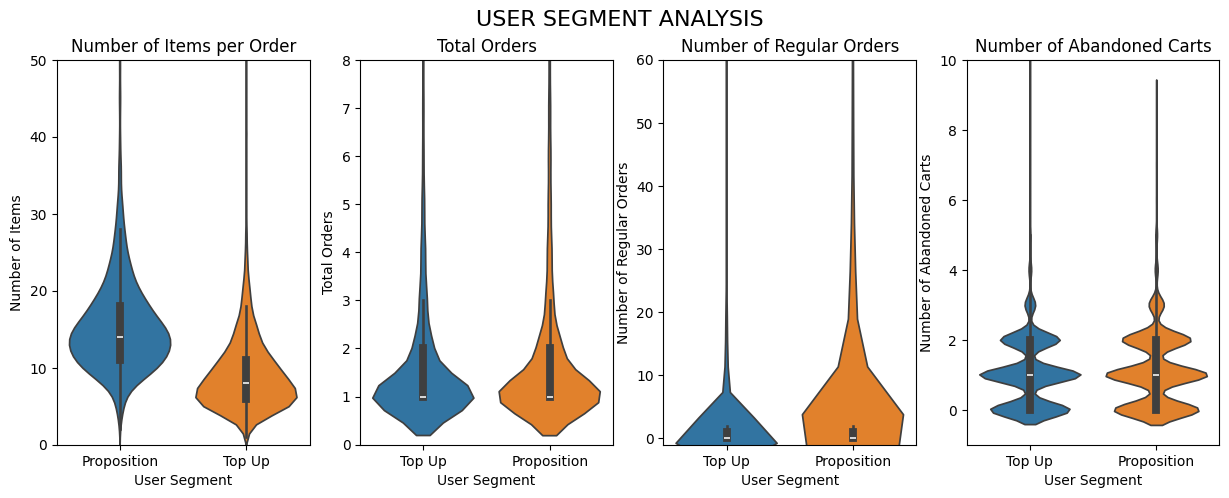

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.violinplot(x='user_segment', y='num_items', data=orders, hue='user_segment')
plt.title("Number of Items per Order")
plt.xlabel("User Segment")
plt.ylabel("Number of Items")
plt.ylim(0, 50) 

plt.subplot(1, 4, 2)
sns.violinplot(x='user_segment', y='total_orders', data=users, hue='user_segment') 
plt.title("Total Orders")
plt.xlabel("User Segment")
plt.ylabel("Total Orders")
plt.ylim(0, 8)

plt.subplot(1, 4, 3)
sns.violinplot(x='user_segment', y='num_regulars', data=users, hue='user_segment') 
plt.title("Number of Regular Orders")
plt.xlabel("User Segment")
plt.ylabel("Number of Regular Orders")
plt.ylim(-1, 60)

plt.subplot(1, 4, 4)
sns.violinplot(x='user_segment', y='num_abandoned_carts', data=users, hue='user_segment') 
plt.title("Number of Abandoned Carts")
plt.xlabel("User Segment")
plt.ylabel("Number of Abandoned Carts")
plt.ylim(-1, 10)

plt.suptitle("USER SEGMENT ANALYSIS", fontsize=16)
plt.show()

Los usuarios _Proposition_ tienden a realizar pedidos de mayor volumen (con más items). Sin embargo, esa parece ser la única diferencia reseñable, pues la distribución del número total de pedidos, el número de compras regulares y el número de productos no comprados es muy similar. Por tanto, el segmento de usuario no parece ser una variable que sea muy informativa por sí misma. Esto no quiere decir que no pueda tener poder predictivo, pues aquí no se ha analizado su comportamiento en combinación con otras variables. 

Algo a destacar de estas gráficas es que las colas de estas distribuciones son bastante largas, lo que implica una aparición frecuente de casos extremos y dificulta la detección de outliers fruto de errores. Sería conveniente analizar las implicaciones en el negocio que tienen estas colas. 

#### **¿Qué productos se venden más?** 

Para poder conocer un poco mejor al negocio, sería adecuado saber qué tipos de productos se venden más. Esto podría dar información acerca de qué productos son los que mayor recaudación suponen para el negocio. 

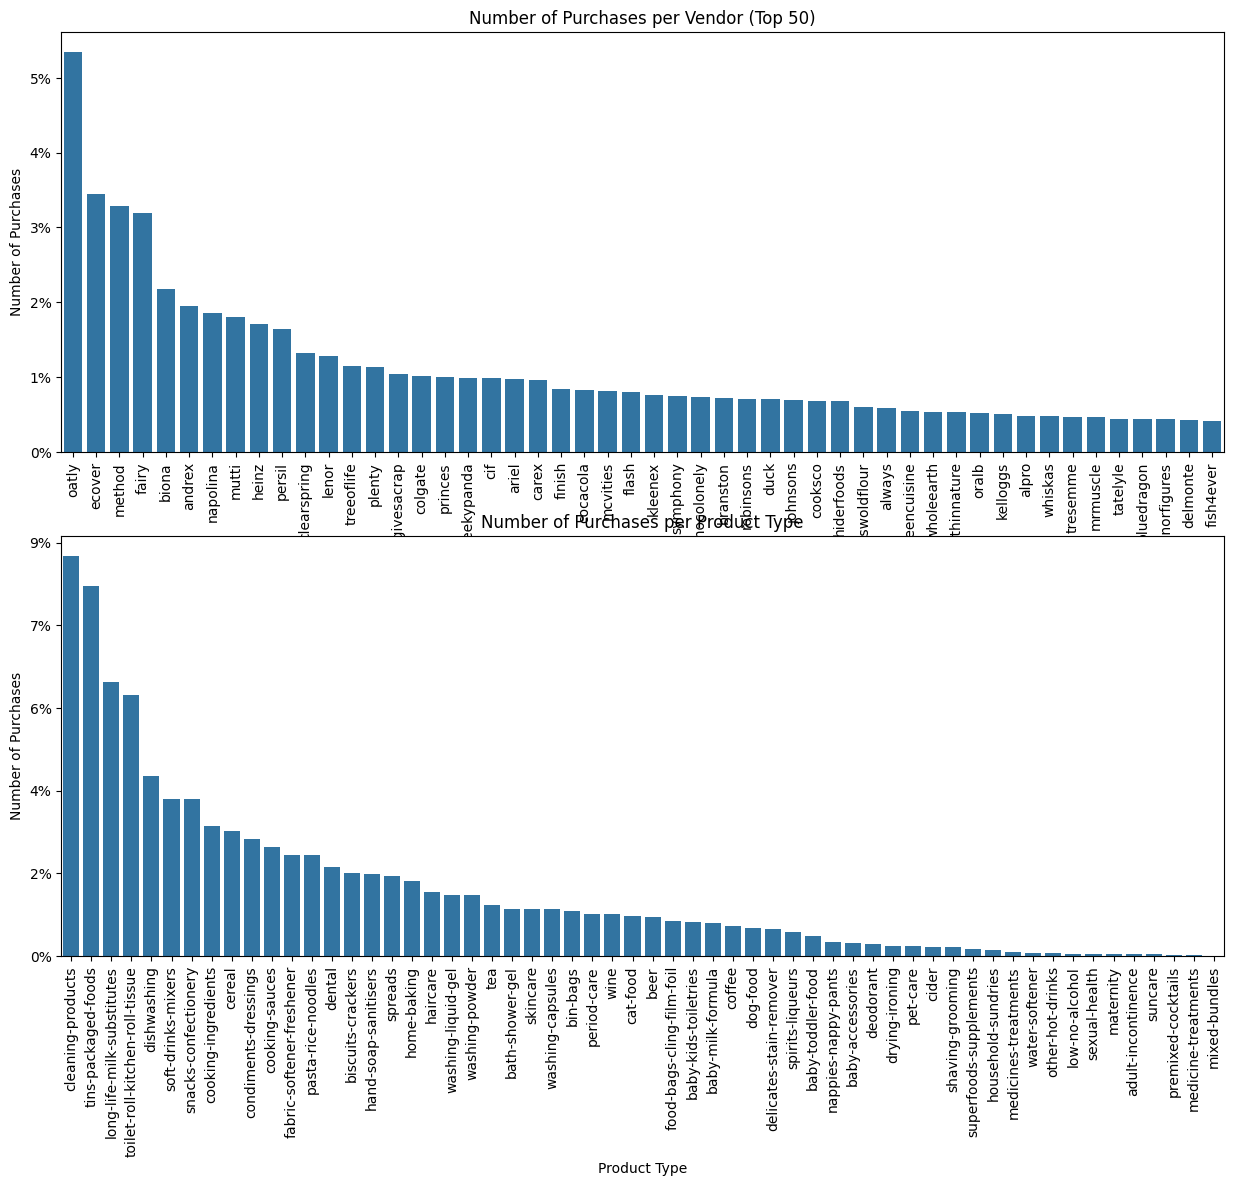

In [5]:
not_found = 0 
total_items_purchased = 0 
purchases_per_item = {} 
for order in orders["ordered_items"]: 
    for item in order: 
        if item not in inventory["variant_id"].values: 
            not_found += 1
        total_items_purchased += 1
        if item in purchases_per_item: 
            purchases_per_item[item] += 1 
        else: 
            purchases_per_item[item] = 1

purchases_per_product_type = {} 
purchases_per_vendor = {} 
for order in orders["ordered_items"]: 
    for item in order: 
        item = int(item)
        if item in inventory["variant_id"].values: 
            product_type = inventory[inventory["variant_id"] == item]["product_type"].values[0]
            vendor = inventory[inventory["variant_id"] == item]["vendor"].values[0]
            if product_type in purchases_per_product_type: 
                purchases_per_product_type[product_type] += 1 
            else: 
                purchases_per_product_type[product_type] = 1
            if vendor in purchases_per_vendor:
                purchases_per_vendor[vendor] += 1
            else:
                purchases_per_vendor[vendor] = 1

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
sorted_vendors = sorted(purchases_per_vendor.items(), key=lambda x: x[1], reverse=True)[:50]
sns.barplot(x=[item[0] for item in sorted_vendors], y=[item[1] for item in sorted_vendors])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format((y / total_items_purchased) * 100)))
plt.xticks(rotation=90)
plt.title("Number of Purchases per Vendor (Top 50)")
plt.xlabel("Vendor")
plt.ylabel("Number of Purchases")

plt.subplot(2, 1, 2)
sorted_items = sorted(purchases_per_product_type.items(), key=lambda x: x[1], reverse=True)
sns.barplot(x=[item[0] for item in sorted_items], y=[item[1] for item in sorted_items])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format((y / total_items_purchased) * 100)))
plt.xticks(rotation=90)
plt.title("Number of Purchases per Product Type")
plt.xlabel("Product Type")
plt.ylabel("Number of Purchases")
plt.show()

In [6]:
sorted_vendors_percentage = [(item[0], (item[1] / total_items_purchased) * 100) for item in sorted_vendors]
print("Top 10 Vendors by Percentage of Total Items Purchased:")
for vendor, percentage in sorted_vendors_percentage[:10]:
    print(f"{vendor}: {percentage:.2f}%")

print("----------------------") 

sorted_items_percentage = [(item[0], (item[1] / total_items_purchased) * 100) for item in sorted_items]
print("\nTop 10 Product Types by Percentage of Total Items Purchased:")
for product_type, percentage in sorted_items_percentage[:10]:
    print(f"{product_type}: {percentage:.2f}%")

Top 10 Vendors by Percentage of Total Items Purchased:
oatly: 4.95%
ecover: 3.19%
method: 3.05%
fairy: 2.95%
biona: 2.02%
andrex: 1.81%
napolina: 1.72%
mutti: 1.67%
heinz: 1.59%
persil: 1.52%
----------------------

Top 10 Product Types by Percentage of Total Items Purchased:
cleaning-products: 8.96%
tins-packaged-foods: 8.30%
long-life-milk-substitutes: 6.15%
toilet-roll-kitchen-roll-tissue: 5.85%
dishwashing: 4.04%
soft-drinks-mixers: 3.53%
snacks-confectionery: 3.51%
cooking-ingredients: 2.92%
cereal: 2.79%
condiments-dressings: 2.61%


Las 10 marcas más vendidas concentran prácticamente el 25% de las compras. En cuanto a tipos de productos, las 10 categorías más vendidas ocupan el 48.66% de las ventas. Estas categorías agrupan productos que necesitan ser repuestos frecuentemente (productos de limpieza, conservas, sucedáneos de leche, ingredientes para cocinar, etc.), lo que indica que el negocio depende en gran medida de productos que se deben comprar de forma recurrente. Ante esto, surge la pregunta de si gran parte de los ingresos del negocio vienen de clientes que utilizan esta web para reponer sus existencias de productos. 

In [7]:
inven = inventory.copy() 
inven['num_sales'] = inven['variant_id'].map(purchases_per_item).fillna(0).astype('Int64')
inven['total_sales_value'] = inven['num_sales'] * inven['price']

sorted_sales_value = inven.groupby('product_type')['total_sales_value'].sum().sort_values(ascending=False)
print("Top 10 Product Types by Percentage of Total Sales Value:")
for product_type, sales_value in sorted_sales_value[:10].items():
    percentage = (sales_value / inven['total_sales_value'].sum()) * 100
    print(f"{product_type}: {percentage:.2f}%")

Top 10 Product Types by Percentage of Total Sales Value:
long-life-milk-substitutes: 14.65%
cleaning-products: 6.52%
toilet-roll-kitchen-roll-tissue: 6.18%
tins-packaged-foods: 5.85%
dishwashing: 5.55%
washing-powder: 4.56%
soft-drinks-mixers: 4.49%
washing-liquid-gel: 3.35%
snacks-confectionery: 3.26%
fabric-softener-freshener: 2.63%


Viendo los tipos de productos que más ventas (en dinero) generan, se confirma la hipótesis de que la mayoría (57.13%) de las ventas son generadas por productos que necesitan ser repuestos frecuentemente. Esta información es valiosa para el negocio, pues conocerla hace que se pueda prestar más atención a los productos que generan la mayoría de los beneficios. Las ventas de estos tipos de productos representarían la zona media y alrededores de la distribución, mientras que el resto podrían ser vistos como eventos de cola. 

Ante esto, cabe preguntarse si la mayor parte de las ventas son realizadas a clientes habituales, pues sería lo lógico que, si los productos que más se venden son productos que deben ser repuestos con regularidad, los clientes usen la web para comprarlos de forma recurrente. Desafortunadamennte, el dataframe `regulars` no cuenta con información de qué productos se establecieron como compras regulares, por lo que habrá que analizarlo de otra forma. 

In [8]:
regulars.head() 

,user_id,variant_id,created_at,user_segment
0,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03,Proposition
1,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35,Proposition
2,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03,Proposition
3,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35,Proposition
4,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11,Top Up


#### **¿Influye la hora del día en las compras?** 
Puesto que se cuenta con información temporal sobre los pedidos, puede aportar información analizar si hay alguna relación entre el momento del día en el que se realiza la compra y el tipo de producto comprado. 

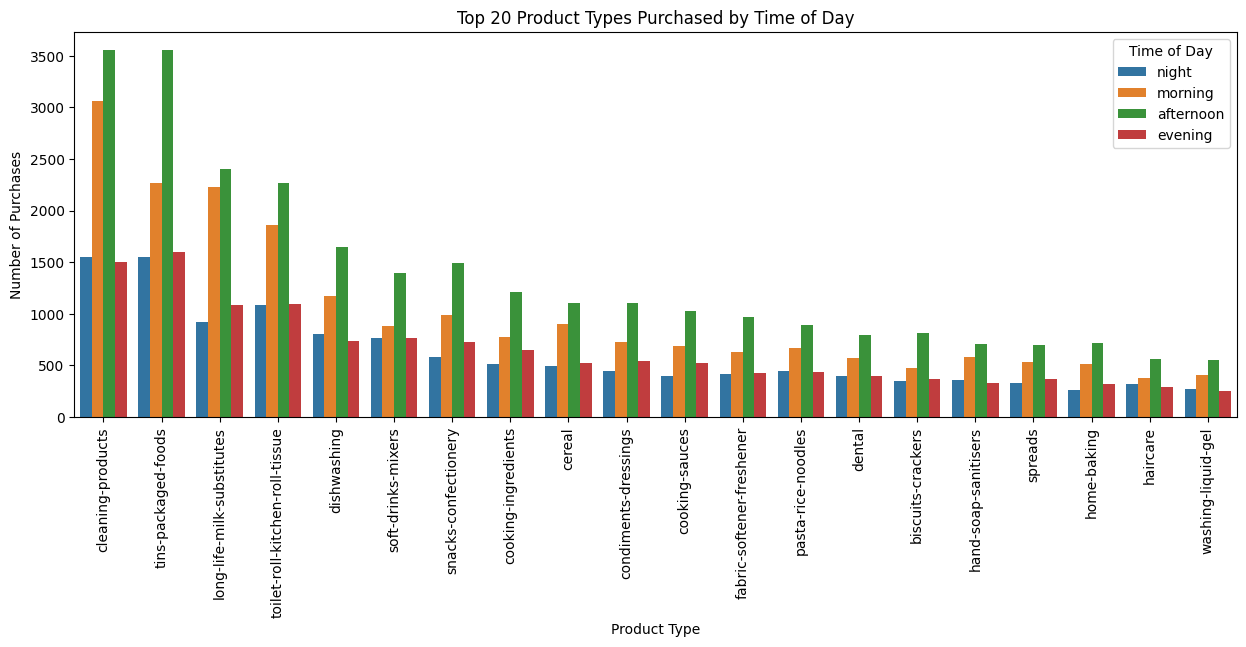

In [9]:
top_10_product_types = [item[0] for item in sorted(purchases_per_product_type.items(), key=lambda x: x[1], reverse=True)[:20]]
orders_expanded = orders.explode('ordered_items')
orders_expanded['ordered_items'] = orders_expanded['ordered_items'].astype(int)
orders_expanded = orders_expanded.merge(inventory[['variant_id', 'product_type']], left_on='ordered_items', right_on='variant_id', how='left')
orders_expanded_top_10 = orders_expanded[orders_expanded['product_type'].isin(top_10_product_types)]
plt.figure(figsize=(15, 5))
sns.countplot(data=orders_expanded_top_10, x='product_type', hue='time_of_day', order=top_10_product_types)
plt.title("Top 20 Product Types Purchased by Time of Day")
plt.xlabel("Product Type")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()

Se observa que todos tipos de productos del top 20 muestran una distribución casi igual, con la gran mayoría de las compras concentradas por la mañana y por la tarde. Por tanto, la hora del día no influye significativamente en el tipo de producto comprado.  

#### **¿Influye la geografía en el comportamiento de compra?** 
Uno de las columnas de los datos de usuarios es `user_nuts1`. Esta columna hace referencia a _Nomenclature of Territorial Units for Statistics_, una forma de hacer referencia a la zona geográfica en la que se encuentra el usuario. En este caso, todos los posibles valoroes empiezan por el prefijo UK, lo que significa que este e-commerce únicamente da servicio a usuarios residentes en Gran Bretaña. Teniendo esta información accesible, resulta conveniente analizar si las zonas de UK presentan diferencias en los patrones de consumo. 

In [10]:
round(users['user_nuts1'].value_counts(normalize=True) * 100, 2)

user_nuts1
UKI    26.72
UKJ    15.11
UKK    12.21
UKH     8.39
UKD     7.26
UKM     6.39
UKE     6.14
UKG     5.98
UKF     5.11
UKL     4.54
UKC     2.07
UKN     0.08
Name: proportion, dtype: float64

Hay ciertas regiones que representan un porcentaje muy poco significativo del conjunto de los usuarios. Su poca representación puede hacer que los estadísticos que se obtengan no sean representativos de la región, por lo que deberán ser excluidos de este análisis. Se excluirán las regiones UKF, UKL, UKC y UKN. 

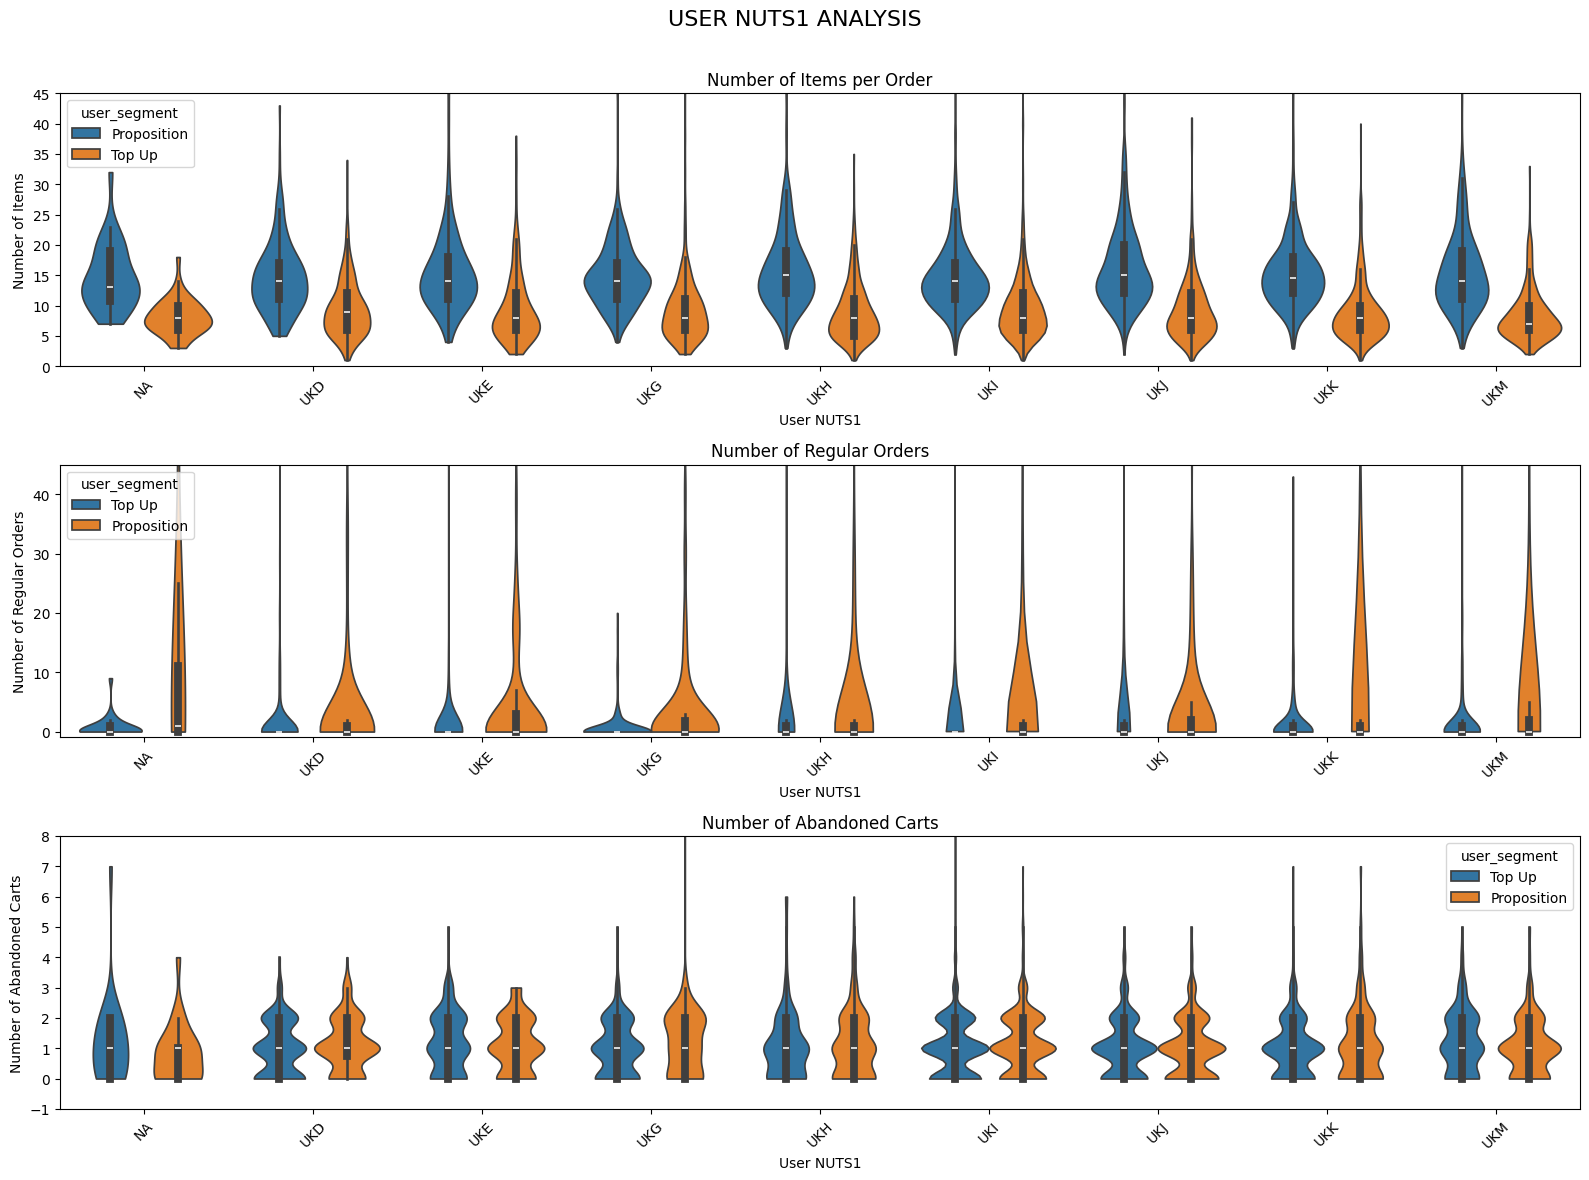

In [11]:
# --- Filtrado y preparación ---
drop_codes = ['UKF', 'UKL', 'UKC', 'UKN']

orders2 = (
    orders.loc[~orders['user_nuts1'].isin(drop_codes)]
          .copy()
          .reset_index(drop=True)
)
users2 = (
    users.loc[~users['user_nuts1'].isin(drop_codes)]
         .copy()
         .reset_index(drop=True)
)

orders2['user_nuts1'] = orders2['user_nuts1'].fillna('NA')
users2['user_nuts1']  = users2['user_nuts1'].fillna('NA')

cats = sorted(pd.unique(pd.concat([orders2['user_nuts1'], users2['user_nuts1']], ignore_index=True)))
orders2['user_nuts1'] = pd.Categorical(orders2['user_nuts1'], categories=cats, ordered=True)
users2['user_nuts1']  = pd.Categorical(users2['user_nuts1'],  categories=cats, ordered=True)

plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
sns.violinplot(x='user_nuts1', y='num_items', data=orders2, hue='user_segment', cut=0)
plt.title("Number of Items per Order")
plt.xlabel("User NUTS1"); plt.ylabel("Number of Items")
plt.ylim(0, 45)
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
sns.violinplot(x='user_nuts1', y='num_regulars', data=users2, hue='user_segment', cut=0)
plt.title("Number of Regular Orders")
plt.xlabel("User NUTS1"); plt.ylabel("Number of Regular Orders")
plt.ylim(-1, 45)
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
sns.violinplot(x='user_nuts1', y='num_abandoned_carts', data=users2, hue='user_segment', cut=0)
plt.title("Number of Abandoned Carts")
plt.xlabel("User NUTS1"); plt.ylabel("Number of Abandoned Carts")
plt.ylim(-1, 8)
plt.xticks(rotation=45)

plt.suptitle("USER NUTS1 ANALYSIS", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

En cuanto al tamaño del pedido, en todas las regiones se observa el comportamiento general analizado con anterioridad: los usuarios _Proposition_ tienden a comprar más cosas en un solo pedido que los _Top Up_. 

El gráfico del centro muestra el número de pedidos regulares en función del segmento para cada zona geográfica. Se observa que los usuarios _Top Up_ realizan un mayor número de pedidos regulares que los _Proposition_. Este dato, unido al que mostraba que más de la mitad de los beneficios vienen por ventas de artículos que necesitan ser repuestos, refuerza la narrativa de que gran parte de los ingresos del negocio vienen por compras recurrentes de artículos perecederos. 

En cuanto al número de productos abandonados, se observa que no hay diferencia entre segmentos, independientemente de la geografía. 

### **CONCLUSIONES GENERALES** 

Tras analizar los datos disponibles, las conclusiones extraídas son: 

- El negocio está situado en Gran Bretaña. 
- Los datos faltantes son referentes a información demográfica. Su ausencia puede ser debida a: 
    - Es un valor 0, pero el usuario no lo ha indicado. 
    - El usuario no quiere revelar esa información. 
- Más de la mitad de los ingresos dependen de productos que necesitan reponer existencias. 
- La mayor parte de las ventas vienen de los usuarios _Top Up_, lo que indica que el negocio se centra principalmente en la venta recurrente de productos que necesitan ser repuestos. 
- Podría ser buena idea que se registrase qué productos se establecen como compras regulares. 
- A priori, el número de objetos abandonados en carrito no aporta información relevante. 

---
### 2. Análisis del dataset limpio 

En esta parte del documento se realizará una exploración del dataset `feature_frame.csv`, el cual ha sido construido a partir de la información disponible en los datos de la primera parte de este análisis. 

In [12]:
file_name = 'feature_frame.csv'
local_file_path = f"data/{file_name}"

data = pd.read_csv(local_file_path)
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [13]:
null_data = data.isnull().sum()
print(null_data[null_data > 0])
data.columns

Series([], dtype: int64)


Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

El dataset está limpio, por lo que carece de valores nulos. 

A continuación, se analizarán las correlaciones de las variables, tanto con el resto de features como con la variable objetivo (`outcome`). 

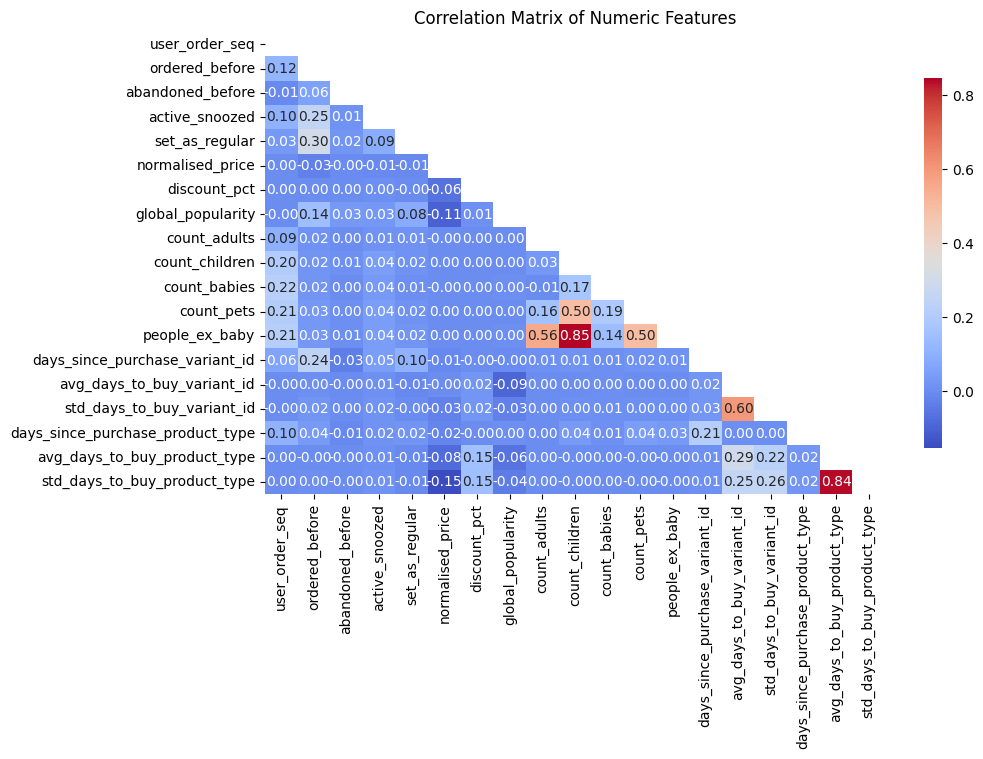

In [14]:
import numpy as np 

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns 
numeric_cols = numeric_cols.drop(['variant_id', 'order_id', 'user_id', 'outcome'], errors='ignore') 
plt.figure(figsize=(10, 6)) 
corr = data[numeric_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Features')
plt.show()

`people_ex_baby` y `count_children`muestran una correlación muy elevada (0.85), ya que ambos cuentan hijos (uno bebés y el otro hijos en general). También hay una correlación alta (0.84) entre `std_days_to_buy_product_type` y `avg_days_to_buy_product_type`, pues ambos son los estadísticos de la distribución de días para comprar el tipo de producto. Hay ciertos datos demográficos que presentan una correlación elevada (mayor de 0.5). Para ver si esta correlación tiene algo de causalidad, habría que realizar un análisis demográfico de la población de las regiones en las que se encuentran los usuarios, cosa que escapa del scope de este análisis. En cuanto al resto de variables, presentan una correlación prácticamente nula entre ellas. 

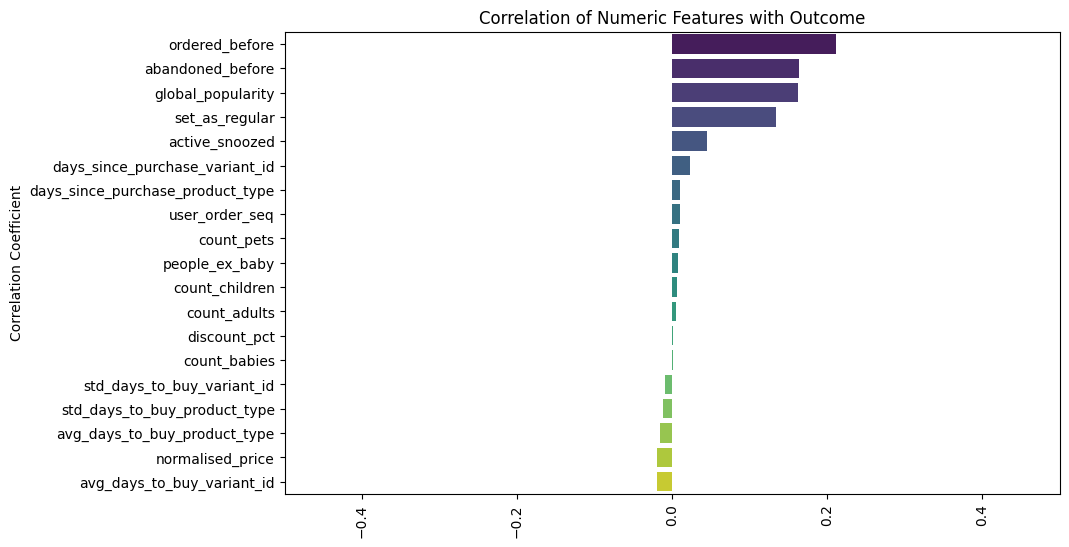

In [15]:
plt.figure(figsize=(10, 6))
corr_outcome = data[numeric_cols].corrwith(data['outcome'])
corr_outcome = corr_outcome.sort_values(ascending=False)
sns.barplot(x=corr_outcome.values, y=corr_outcome.index, hue=corr_outcome.index, palette='viridis')
plt.xlim(-0.5, 0.5)
plt.xticks(rotation=90)
plt.title('Correlation of Numeric Features with Outcome')
plt.ylabel('Correlation Coefficient')
plt.show()

Las correlaciones de las variables con el target `outcome` son bajas, con un valor máximo de 0.2 para `ordered_before`. Sin embargo, considerar el coeficiente de correlación aislado no es un buen indicativo de poder predictivo de la variable, pues únicamente mide la relación lineal individual de dicha variable con el target. Cabe la posibilidad de que el poder predictivo de una variable sea notorio cuando actúa en combinación con otras, o que la relación con el target sea no lineal. Por tanto, no se pueden extraer conclusiones sobre qué variables pueden ser o no de utilidad en base a este análisis de correlaciones. Para determinarlo con mayor seguridad, se deberá acudir al análisis de feature importance una vez entrenados diferentes modelos. 

#### Análisis de las distribuciones de las variables 

In [16]:
numeric_cols

Index(['user_order_seq', 'ordered_before', 'abandoned_before',
       'active_snoozed', 'set_as_regular', 'normalised_price', 'discount_pct',
       'global_popularity', 'count_adults', 'count_children', 'count_babies',
       'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [17]:
data['active_snoozed'].nunique()

2

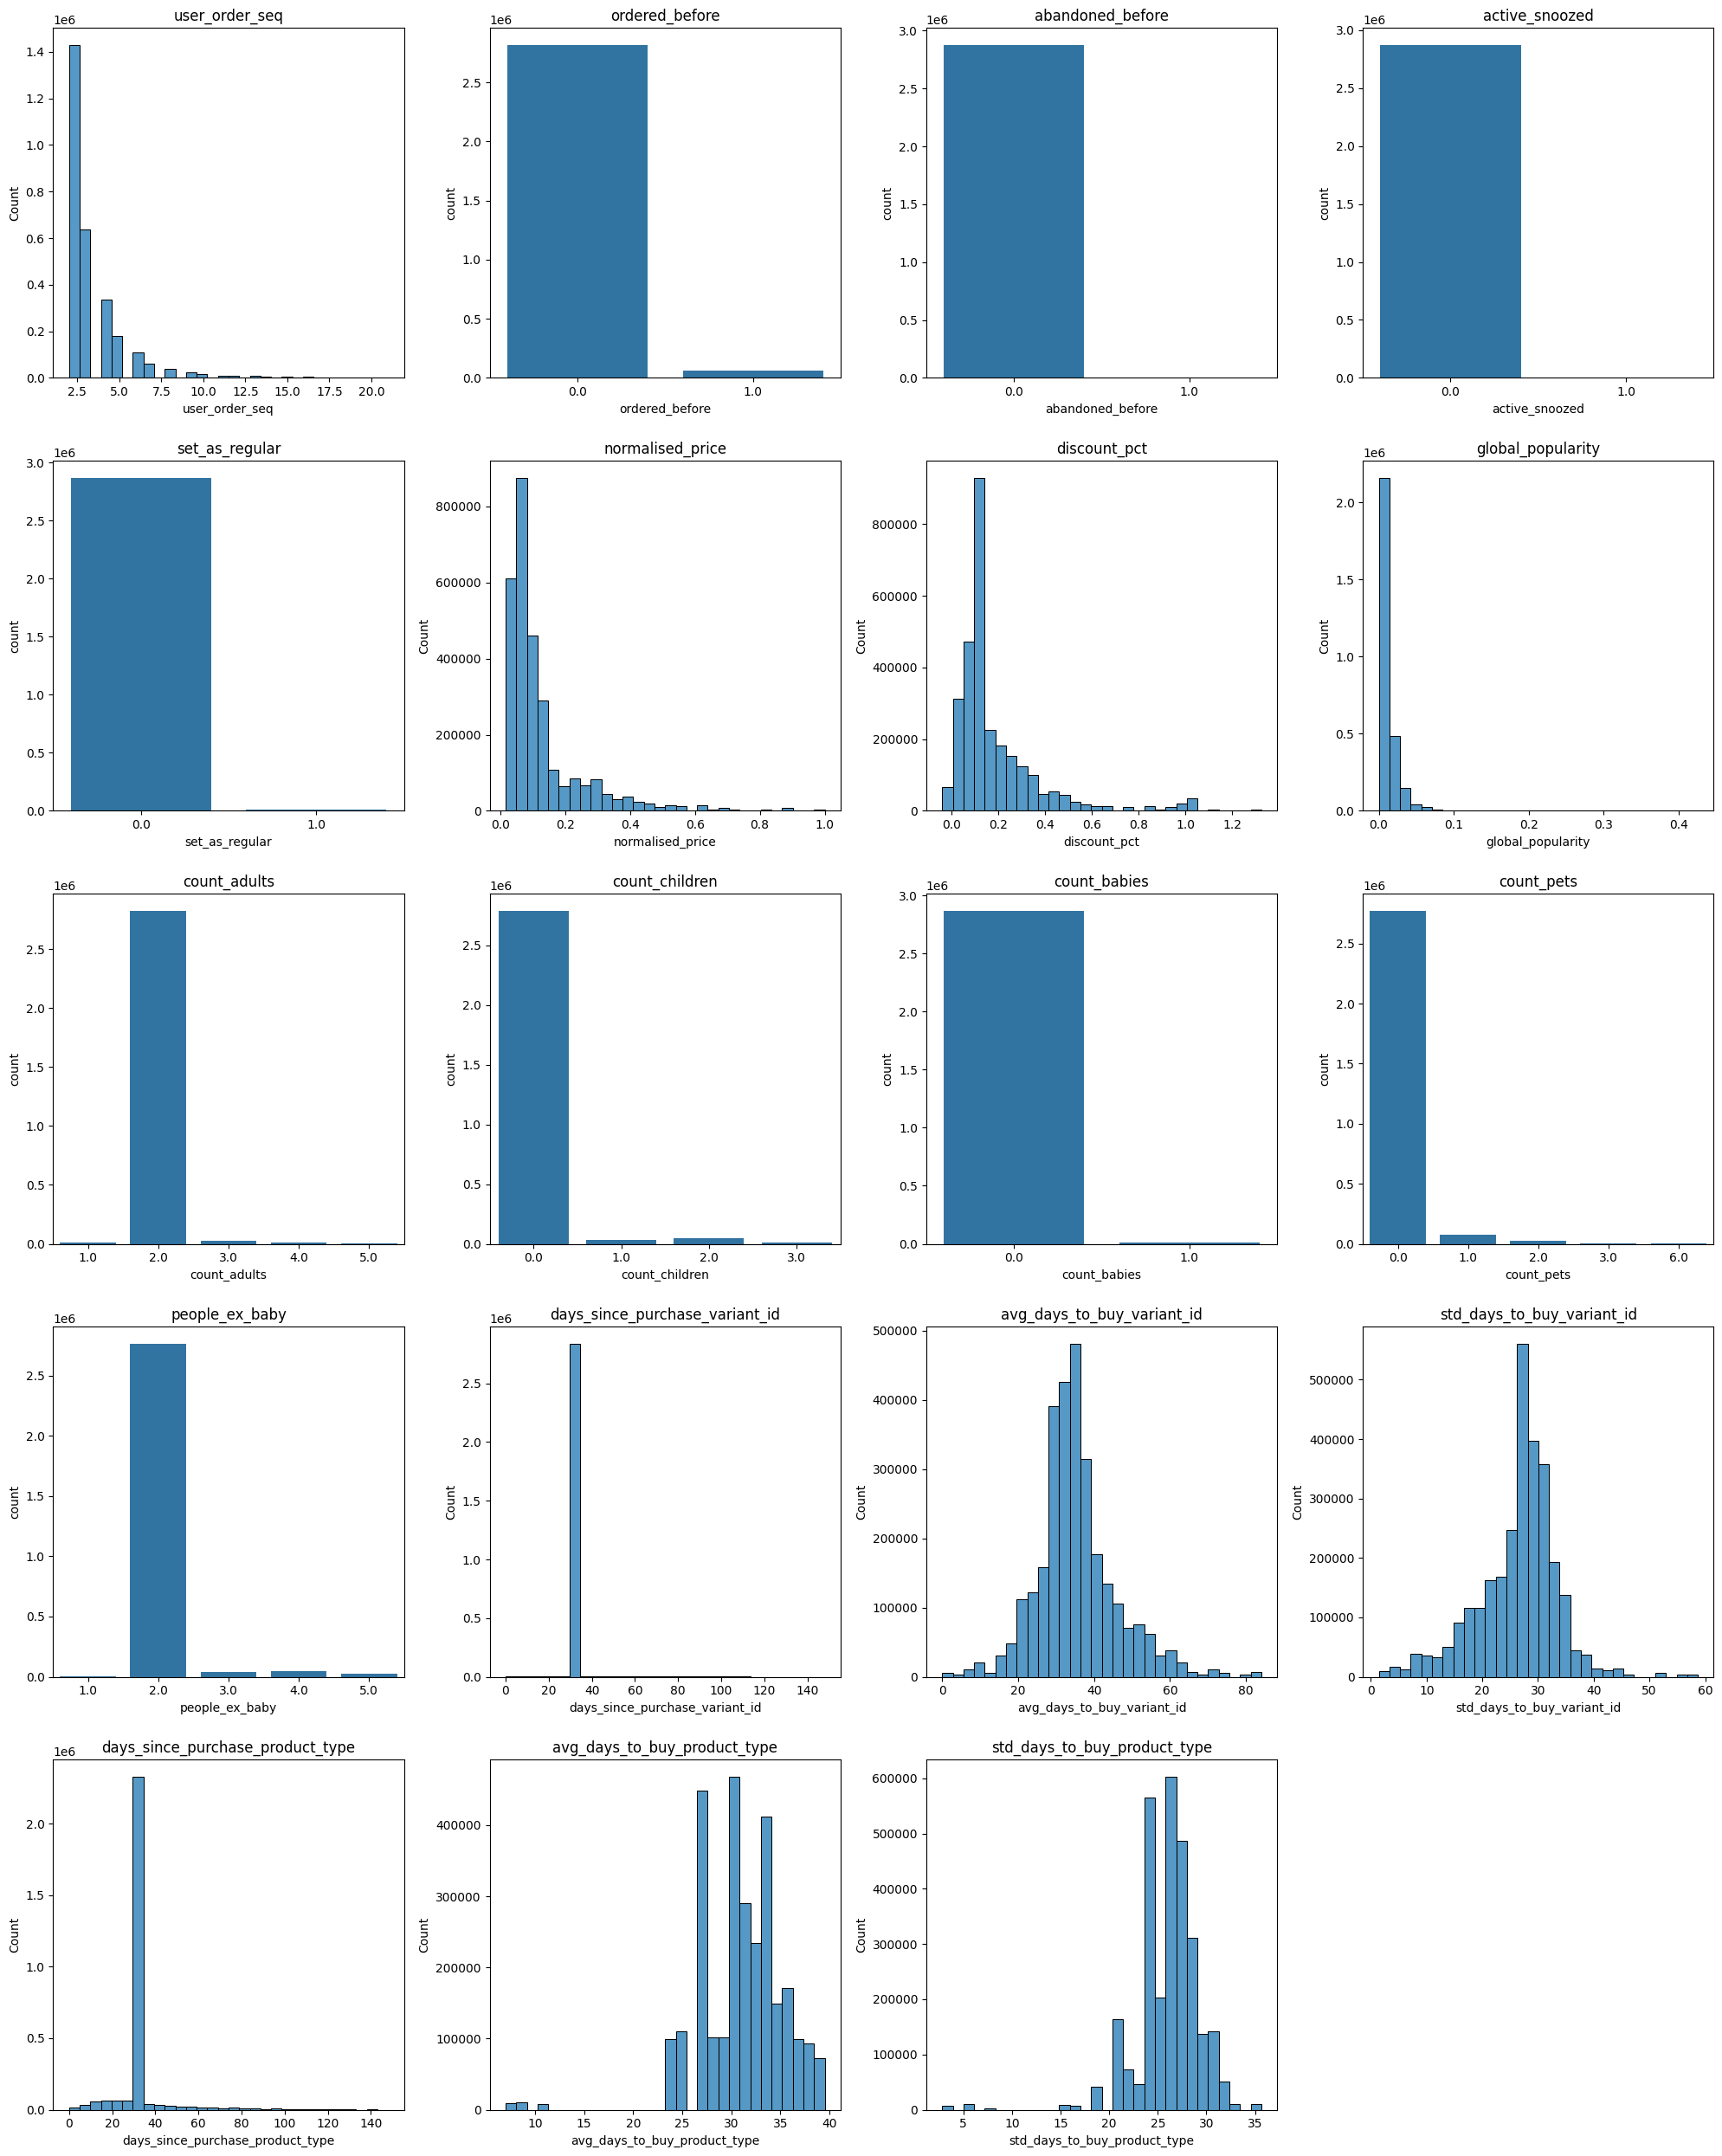

In [18]:
n = len(numeric_cols)
rows = (n // 4) + 1 
plt.figure(figsize=(20, 5*rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 4, i)
    if data[col].nunique() <= 1: 
        plt.text(0.5, 0.5, 'Constant Value', horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')
    elif data[col].nunique() < 20:
        sns.countplot(x=col, data=data)
    else:
        sns.histplot(data[col].dropna(), kde=False, bins=30)
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

In [19]:
data['outcome'].value_counts(normalize=True) * 100

outcome
0.0    98.846331
1.0     1.153669
Name: proportion, dtype: float64

La distribución de `user_order_seq` muestra que la gran mayoría de clientes han realizado pocas compras en la plataforma, y que solo unos pocos son clientes habituales. Esto también se puede ver en `ordered_before`, pues en la gran mayoría de los casos es la primera vez que se compra un producto. 

El dataset muestra un fuerte desbalanceo en las variables binarias. Esto puede ser fruto de la imputación empleada para tratar los valores faltantes. Con casi total seguridad, se han sustituido los valores NaN por ceros. Pese a que un NaN en un campo de información demográfica puede significar lo mismo que 0, hay que considerar la posibilidad de que ese valor faltante sea debido a que el usuario no quiere proporcionar esa información. De cara al futuro entrenamiento de un algoritmo, sería una buena idea añadir features que indiquen si se ha realizado alguna imputación, para así poder analizar su influencia en la fase de análisis del modelo. 

Otros histogramas reveladores son los de `avg_days_to_buy_product_type` y `avg_days_to_buy_variant_id`. Estos histogrmas muestran que casi todos los productos son comprados de forma recurrente cada 20-40 días, lo que refuerza aún más la narrativa de que la mayoría de productos de este negocio son de naturaleza perecedera o que son usados frecuentemente (leche, productos de limpieza, ingredientes de cocina, etc., tal y como se mencionó en el primer apartado del análisis). Por tanto, podemos afirmar que, al menos en este aspecto, el dataset es representativo de la población que estamos tratando de modelar. 